In [1]:
from __future__ import print_function
from ase.io import *
import numpy as np
from ase.units import Bohr
from kqeq import kernel_qeq, get_dipoles
from kqeq.kernel import kernel
import time

In [2]:
# This uses a fixed seed to get the same 'random' set every time
def randomize_dataset(dataset):
    nmols = len(dataset)
    indices = np.arange(nmols)
    np.random.seed(42) 
    np.random.shuffle(indices)
    newset = []
    for i in indices:
        newset.append(dataset[i])
    return newset

In [3]:
# Get data (and randomize training)
mols_train = read("data/carsten_data/QMtrain.xyz@:",format='extxyz')
mols_train = randomize_dataset(mols_train)
mols_valid = read("data/carsten_data/ValQM9.xyz@:",format='extxyz')
mols_test  = read("data/carsten_data/TestQM9.xyz@:",format='extxyz')


This notebook can be used to make learning curves. There are some differences to the API, which I added to accelerate training and validation and/or increase accuracy:

1) Kernels are now redefined for every training set. This is because I implemented an option to pass training and validation sets to the Kernel object, so that these SOAP vectors don't have to be recomputed every time. This is probably not really necessary in the long run, since the Kernel generation is not rate limiting. The old syntax should still work (at least the tutorial still runs). I guess the old way may be preferable, since it avoids errors when hyperparameters are changed at one point of the kernel but not the other (e.g. between training and prediction). I try to avoid this by defining all hypers as variables in a single place in the notebook.

2) There is now an radius_type option for the kqeq object, which can be 'rcov' (old default) or 'qeq'. Using scaled radii from the original qeq seems preferable and should become the default in the future. I use this here. Be careful not to mix radius_type or scale_atsize between training and prediction.

3) The kqeq object now also accepts a validation set, which allows precomputing the corresponding hardness matrix. The predict method has a kerneltype option, which takes advantage of the precomputed descriptors in the kernel object.

4) The linear algebra routines in the training method have been revamped and are much faster now (factor 4 in my experience). This is the most important change, since training time was actually rate determining (perhaps surprisingly).  

In [4]:
print(len(mols_train))
print(len(mols_valid))
print(len(mols_test))

5285
1000
1000


In [5]:
# Functions for Error measures (note the Debye conversion factor in second function)
def calc_MAE(dip1,dip2):
    return np.mean(np.abs(dip1-dip2))

def calc_MAE_abs_dipole_debye(dip1,dip2):
    n_dipoles = int(len(dip1)/3)
    dipoles1 = np.reshape(dip1,(n_dipoles,3))
    dipoles2 = np.reshape(dip2,(n_dipoles,3))
    return (np.mean(np.abs(np.linalg.norm(dipoles1,axis=1)-np.linalg.norm(dipoles2,axis=1))))*2.541746229

    

In [6]:
# Learning curve loop
min_mae_train = []
min_mae_val   = []
min_reg       = []

# Global definition of hypers up here, to avoid errors:
r_cut  = 1.75
lmax = 2
nmax = 6
scale_atom = 0.75
radius_type = 'qeq'

print('# ntrain lambda  MAE_valid  MAE_train')
for ntrain in [100,200]:
    desdict = {"nmax" : nmax,
           "lmax" : lmax,
           "rcut" : r_cut,
           "sigma": r_cut/8.,
           "periodic": False}
    
    t0 = time.time()
    SOAP_Kernel = kernel(Kernel='SOAP',Descriptor='SOAP',multi_SOAP=False,descriptor_dict=desdict,training_set=mols_train[:ntrain],validation_set=mols_valid)
    #print('kernel setup in',time.time()-t0)
    
    # Get reference values from atoms objects
    dipoles_v_ref = get_dipoles(mols_valid)
    dipoles_t_ref = get_dipoles(mols_train[:ntrain])

    #t0 = time.time()
    my_kqeq = kernel_qeq(training_set=mols_train[:ntrain],validation_set=mols_valid,Kernel=SOAP_Kernel,scale_atsize=scale_atom,radius_type=radius_type)
    #print('kqeq setup in',time.time()-t0)

    minval   = 1e7
    minreg   = 0.0
    #t0 = time.time()
    for lambda_reg in [1e-3,5e-3,1e-2,5e-2,1e-1]:
        # Train a model with a given regularization parameter
        my_kqeq.train(lambda_reg=lambda_reg)
        #print('training done in',time.time()-t0)

        # Predict dipole moments for training and validation set
        #t0 = time.time()
        dipoles_v, charges_v, enegs_v = my_kqeq.predict(mols_valid,kerneltype='validation')
        #print('predict val done in ',time.time()-t0)
        #t0 = time.time()
        dipoles_t, charges_t, enegs_t = my_kqeq.predict(mols_train[:ntrain],kerneltype='training')
        #print('predict train done in',time.time()-t0)
        mae_val   = calc_MAE_abs_dipole_debye(dipoles_v,dipoles_v_ref)
        mae_train = calc_MAE_abs_dipole_debye(dipoles_t,dipoles_t_ref)
        if mae_val < minval:
            minval   = mae_val
            mintrain = mae_train
            minreg   = lambda_reg
        
    print(ntrain,minreg,minval,mintrain,time.time()-t0)
    min_mae_train.append(mintrain)
    min_mae_val.append(minval)
    min_reg.append(minreg)
    

# ntrain lambda  MAE_valid  MAE_train
100 0.1 0.5012537618722863 0.23308817846251145 70.8843719959259
200 0.001 0.2833512796929807 0.10620316399971601 180.66273760795593


In [ ]:
# Learning curve loop
min_mae_train = []
min_mae_val   = []
min_reg       = []

# Global definition of hypers up here, to avoid errors:
r_cut  = 1.75
lmax = 2
nmax = 6
scale_atom = 0.75
radius_type = 'qeq'

print('# ntrain lambda  MAE_valid  MAE_train')
for ntrain in [100,200]:
    desdict = {"nmax" : [nmax,nmax],
           "lmax" : [lmax,lmax],
           "rcut" : [r_cut,r_cut*2],
           "sigma": [r_cut/8.,r_cut/4],
           "deltas":[0.75,0.25],
           "periodic": [False,False]}
    
    t0 = time.time()
    SOAP_Kernel = kernel(Kernel='SOAP',Descriptor='SOAP',multi_SOAP=True,descriptor_dict=desdict,training_set=mols_train[:ntrain],validation_set=mols_valid)
    #print('kernel setup in',time.time()-t0)
    
    # Get reference values from atoms objects
    dipoles_v_ref = get_dipoles(mols_valid)
    dipoles_t_ref = get_dipoles(mols_train[:ntrain])

    #t0 = time.time()
    my_kqeq = kernel_qeq(training_set=mols_train[:ntrain],validation_set=mols_valid,Kernel=SOAP_Kernel,scale_atsize=scale_atom,radius_type=radius_type)
    #print('kqeq setup in',time.time()-t0)

    minval   = 1e7
    minreg   = 0.0
    #t0 = time.time()
    for lambda_reg in [1e-3,5e-3,1e-2,5e-2,1e-1]:
        # Train a model with a given regularization parameter
        my_kqeq.train(lambda_reg=lambda_reg)
        #print('training done in',time.time()-t0)

        # Predict dipole moments for training and validation set
        #t0 = time.time()
        dipoles_v, charges_v, enegs_v = my_kqeq.predict(mols_valid,kerneltype='validation')
        #print('predict val done in ',time.time()-t0)
        #t0 = time.time()
        dipoles_t, charges_t, enegs_t = my_kqeq.predict(mols_train[:ntrain],kerneltype='training')
        #print('predict train done in',time.time()-t0)
        mae_val   = calc_MAE_abs_dipole_debye(dipoles_v,dipoles_v_ref)
        mae_train = calc_MAE_abs_dipole_debye(dipoles_t,dipoles_t_ref)
        if mae_val < minval:
            minval   = mae_val
            mintrain = mae_train
            minreg   = lambda_reg
        
    print(ntrain,minreg,minval,mintrain,time.time()-t0)
    min_mae_train.append(mintrain)
    min_mae_val.append(minval)
    min_reg.append(minreg)

# ntrain lambda  MAE_valid  MAE_train
100 0.1 0.4137359804951505 0.09351690589489214 141.49084091186523


0.13638890221322045 0.21179667249100775


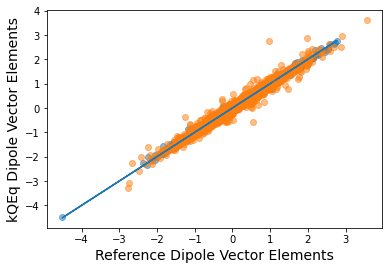

In [38]:
# Train a model with a given regularization parameter for further analysis
ntrain = 100

desdict = {"nmax" : nmax,
           "lmax" : lmax,
           "rcut" : r_cut,
           "sigma": r_cut/8.,
           "periodic": False}
    
SOAP_Kernel = kernel(Kernel='SOAP',Descriptor='SOAP',descriptor_dict=desdict,training_set=mols_train[:ntrain],validation_set=mols_valid)

my_kqeq = kernel_qeq(training_set=mols_train[:ntrain],validation_set=mols_valid,Kernel=SOAP_Kernel,scale_atsize=scale_atom,radius_type=radius_type)
my_kqeq.train(lambda_reg=0.001)

mols_test  = read("data/carsten_data/TestQM9.xyz@:",format='extxyz')
dipoles_v_ref = get_dipoles(mols_test)
dipoles_t_ref = get_dipoles(mols_train[:ntrain])

# Predict dipole moments for training and validation set
dipoles_v, charges_v, enegs_v = my_kqeq.predict(mols_test)
dipoles_t, charges_t, enegs_t = my_kqeq.predict(mols_train,kerneltype='training')
print(calc_MAE_abs_dipole_debye(dipoles_t,dipoles_t_ref),calc_MAE_abs_dipole_debye(dipoles_v,dipoles_v_ref))

# Plot the results
import matplotlib.pyplot as plt
plt.scatter(dipoles_t_ref,dipoles_t,alpha=0.5)
plt.scatter(dipoles_v_ref,dipoles_v,alpha=0.5)
plt.plot(dipoles_t_ref,dipoles_t_ref)
plt.xlabel('Reference Dipole Vector Elements',fontsize=14)
plt.ylabel('kQEq Dipole Vector Elements',fontsize=14)
plt.show()

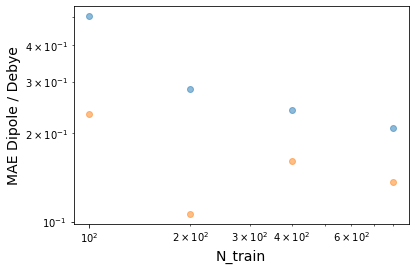

In [35]:
plt.scatter([100,200,400,800],min_mae_val,alpha=0.5)
plt.scatter([100,200,400,800],min_mae_train,alpha=0.5)
plt.yscale('log')
plt.xscale('log')

plt.xlabel('N_train',fontsize=14)
plt.ylabel('MAE Dipole / Debye',fontsize=14)
plt.show()

In [8]:
calc_MAE_abs_dipole_debye(dipoles_v_ref,dipoles_v)

0.21985951663809247

In [9]:
n_dipoles = int(len(dipoles_v)/3)
dipoles1 = np.reshape(dipoles_v,(n_dipoles,3))
norms = np.linalg.norm(dipoles1,axis=1)
print(len(norms))

1000


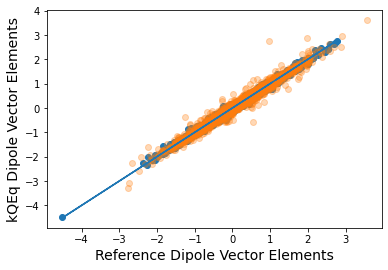

In [33]:
import matplotlib.pyplot as plt
dipoles_t_ref = get_dipoles(mols_train[:800])

plt.scatter(dipoles_t_ref,dipoles_t)
plt.scatter(dipoles_v_ref,dipoles_v,alpha=0.3)
plt.plot(dipoles_t_ref,dipoles_t_ref)
plt.xlabel('Reference Dipole Vector Elements',fontsize=14)
plt.ylabel('kQEq Dipole Vector Elements',fontsize=14)
plt.show()

In [5]:
t0 = time.time()
my_kqeq = kernel_qeq(training_set=mols_train,validation_set=mols_valid,Kernel=SOAP_Kernel,scale_atsize=1.0)
print('kqeq setup in',time.time()-t0)

t0 = time.time()
my_kqeq.train(lambda_reg=0.01)
print('training done in',time.time()-t0)

kqeq setup in 60.48204779624939
training done in 89.19047617912292


In [9]:
from scipy.linalg import cho_factor, cho_solve

def train(mykqeq,lambda_reg=0.1):
    t0 = time.time()
    A_bar = mykqeq.A_bar
    K = mykqeq.K_train
    R = mykqeq.R
    mu_ref = mykqeq.mu_ref
    print('get arrays',time.time()-t0)
    
    t0 = time.time()
    #tmp = np.matmul(A_bar.T,np.matmul(R.T,np.matmul(R,np.matmul(A_bar,K))))
    tmp = np.linalg.multi_dot([A_bar.T,R.T,R,A_bar,K])

    print('first mult',time.time()-t0)

    t0 = time.time()
    #tmp = np.linalg.inv(tmp+lambda_reg*np.eye(K.shape[0]))
    tmp1 = tmp+lambda_reg*np.eye(K.shape[0])
    tmp2 = -np.linalg.multi_dot([A_bar.T,R.T,mu_ref])
    print('second mult',time.time()-t0)

    t0 = time.time()
    #weights = -np.matmul(np.matmul(tmp,np.matmul(A_bar.T,R.T)),mu_ref)
    #weights = -np.linalg.multi_dot([tmp,A_bar.T,R.T,mu_ref])
    weights  = np.linalg.solve(tmp1,tmp2)
    print('third mult',time.time()-t0)   
    return weights
    

In [19]:
weights_matmul = train(my_kqeq,lambda_reg=0.1)

get arrays 1.1920928955078125e-06
first mult 96.4308009147644
second mult 56.04825305938721
third mult 18.054354906082153


In [24]:
weights_multidot = train(my_kqeq,lambda_reg=0.1)

get arrays 1.9073486328125e-06
first mult 31.755419731140137
second mult 55.940579652786255
third mult 0.029092788696289062


In [25]:
print(weights_matmul)

[ 0.11819279  1.36605752 -1.51143274 ... -0.79084512 -0.52313799
  0.43004288]


In [26]:
print(weights_multidot)

[ 0.11819279  1.36605752 -1.51143274 ... -0.79084512 -0.52313799
  0.43004288]


In [7]:
weights_solve = train(my_kqeq,lambda_reg=0.1)

get arrays 3.0994415283203125e-06
first mult 30.557365655899048
second mult 0.7335250377655029
third mult 17.031880378723145


In [8]:
print(weights_solve)

[ 0.11819279  1.36605752 -1.51143274 ... -0.79084512 -0.52313799
  0.43004288]


In [10]:
weights_cho = train(my_kqeq,lambda_reg=0.1)

get arrays 1.6689300537109375e-06
first mult 29.315760374069214
second mult 0.733057975769043


LinAlgError: 3-th leading minor of the array is not positive definite

In [30]:
2*43*43*4

14792

In [31]:
12**4

20736